#### [数据集说明 dataset description]

##### 数据来源 Data Sources

[数据来源](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

##### 数据结构 data structure

见struct.jpg

#### 一、环境配置 Environment configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# 修改imputer为SimpleImputer
# from sklearn.preprocessi|ng import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

import seaborn as sns
import cv2
# from sklearn.metrics import roc_curve, auc, roc_auc_score

#### 二、数据信息配置 Data information configuration

In [2]:
# 定义根路径
# root =  '/Users/authorcai/Documents/Authorcai/CSH/HumanActivityRecognize-master/Data/UCI_HAR_Dataset/'
root = 'C:/Users/Authorcai/CSH/HumanActivityRecognization/UCI_HAR_Dataset/UCI_HAR_Dataset/'

In [3]:
# 读取数据
features = pd.read_csv(root + 'features.txt', sep='\s+', index_col=0, header=None)
train_data = pd.read_csv(root + 'train/X_train.txt', sep='\s+', names=features.values.ravel().tolist(),header=None)
test_data = pd.read_csv(root + 'test/X_test.txt', sep='\s+', names=features.values.ravel().tolist(),header=None)
train_label = pd.read_csv(root + 'train/y_train.txt', sep='\s+', header=None)
test_label = pd.read_csv(root + 'test/y_test.txt', sep='\s+', header=None)
label_name = pd.read_csv(root + 'activity_labels.txt', sep='\s+', header=None)

# drop掉label_name自带的索引列
label_name = label_name.drop(columns=0,axis=1)

In [4]:
# 处理label数据
def get_label_name(num):
    return label_name.iloc[num-1,0]#在原来的标签号基础上减一


In [5]:
train_data['label']=train_label
test_data['label']=test_label

In [6]:
# 匹配索引号和对应姿势名称
train_data['label_name']=train_data['label'].map(get_label_name)
test_data['label_name']=test_data['label'].map(get_label_name)

# 查看train_data是否匹配成功
pd.DataFrame(train_data['label_name'])['label_name'].value_counts()
# 查看test_data是否匹配成功
#pd.DataFrame(test_data['label_name'])['label_name'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: label_name, dtype: int64

##### （一）处理空值 Handling null values

In [7]:
# 将初始数据的空值用NaN替代
train_data.replace("?",np.NaN).head()
test_data.replace("?",np.NaN).head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,label_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,5,STANDING


##### （二）处理缺省值 Handling default values

In [8]:
# 无缺省，无需处理缺省值

##### （三）训练集和测试集信息说明 Training set and test set information description

In [9]:
print("训练集样本模型:%d，特征属性：%d, 目标属性:%d " %(train_data.shape[0],train_data.shape[1],train_label.shape[1]))

训练集样本模型:7352，特征属性：563, 目标属性:1 


In [10]:
print("训练集样本模型:%d，特征属性：%d, 目标属性:%d " %(test_data.shape[0],test_data.shape[1],train_label.shape[1]))

训练集样本模型:2947，特征属性：563, 目标属性:1 


##### （四）根据算法要求处理数据  Process data according to algorithm requirements

In [11]:
#制作训练集和测试集，使格式符合sklean算法要求
x_train=train_data.iloc[:,:-2].values # 训练集X特征数据
x_test=train_data.iloc[:,-2].values # 训练集X标签数据
y_train=test_data.iloc[:,:-2].values # 测试集Y合特征数据
y_test=test_data.iloc[:,-2].values # 测试集Y标签数据


#### 三、建立投票分类模型训练

* 前期准备

In [12]:
names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'
}

In [13]:
# 定义函数用于生成混淆矩阵
def CreateCM(prediction,y_true,name):
    # 查看结果
    prediction_new = pd.DataFrame(prediction)
    prediction_new.columns=['activity']
    # 对预测结果数量进行统计
    # prediction_new['activity'].value_counts()
    # 对预测结果标签进行数字替换，按names进行替换
    prediction_new['activity']= prediction_new['activity'].map(names)
    # 查看预测结果信息
    # prediction_new['activity'].describe()
    # prediction_new['activity'].value_counts()
    
#     # 对prediciton 作-1处理
#     i = 0
#     for value in prediction:
#         prediction[i]=value-1
#         i = i+1
#     # 对y_test 作-1处理
#     i = 0
#     for value in y_test:
#         y_true[i]=value-1
#         i = i+1
    # 混淆矩阵可视化
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import plot_confusion_matrix
    # 生成获取混淆矩阵
    cm = confusion_matrix(y_true=y_true,y_pred=prediction)   
    
    # 混淆矩阵信息添加
    columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    cm_df = pd.DataFrame(cm)
    cm_df.columns = columns
    cm_df.index = columns

    #转换成dataframe，转不转一样
    #fmt参数不使用科学计数法进行显示
#     plt.xticks(fontsize=8) 
#     plt.yticks(fontsize=8)
    ax = sns.heatmap(cm_df,annot=True,fmt='.20g',center=120,vmin=0,vmax=600)
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    
    # 存储图片
    # plt.savefig('论文图表资料/其他对比算法的预测结果（混淆矩阵展示）/'+name+'.tif',format='tif',bbox_inches='tight')
    # 设置xy轴刻度文字大小 
    return cm

In [14]:
#test
a = np.array([
    [1,2,3],
    [1,2,3],
    [1,2,3]
])


In [15]:
# 定义函数用于输出精确率和召回率
def process(cm):
    x = [0,0,0,0,0,0]
    y = [0,0,0,0,0,0]
    for i in range(0,6):
        sumrow_i = sum(cm[i])
        sumcol_i = sum(cm.T[i])

        x[i] = cm[i][i]/sumrow_i
        y[i] = cm[i][i]/sumcol_i
    print("精确率：",np.sum(x)/6*100,'%' )
    print("召回率：",np.sum(y)/6*100,'%' )

##### （一）构建各类分类模型

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
# 定义各训练模型
clf1 = KNeighborsClassifier()
clf2 = SVC(kernel='rbf', probability=True)
clf3 = QuadraticDiscriminantAnalysis()
clf4 = GaussianNB()
clf5 = MLPClassifier()
clf6 = LogisticRegression()

# 联合训练，投票方式为硬投票
summary = [('KNN',clf1),('SVM',clf2),('QDA',clf3),('GaussianNB',clf4),('MLP',clf5),('LR',clf6)]
eclf = VotingClassifier(estimators=summary, voting='hard')
#使用投票法,voting='hard'表示硬投票

##### （二）训练模型-硬投票

In [61]:
eclf.fit(x_train,x_test)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('SVM', SVC(probability=True)),
                             ('QDA', QuadraticDiscriminantAnalysis()),
                             ('GaussianNB', GaussianNB()),
                             ('MLP', MLPClassifier()),
                             ('LR', LogisticRegression())])

In [24]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
for clf, clf_name in zip([clf1, clf2, clf5, clf6, eclf],['KNN', 'SVM', 'MLP','LR', 'Voting']):
    scores = cross_val_score(clf, x_train, x_test, cv=5, scoring='accuracy')
    print('Accuracy: {:.2f} (+/- {:.2f}) [{}]'.format(scores.mean(), scores.std(), clf_name))

Accuracy: 0.90 (+/- 0.02) [KNN]
Accuracy: 0.93 (+/- 0.02) [SVM]
Accuracy: 0.93 (+/- 0.02) [MLP]
Accuracy: 0.93 (+/- 0.03) [LR]
Accuracy: 0.93 (+/- 0.02) [Voting]


##### （三）训练模型-软投票直接选择前两列特征

In [52]:
from itertools import product
x_t = x_train[:,[0,2]]
clf1.fit(x_t,x_test)
clf2.fit(x_t,x_test)
clf3.fit(x_t,x_test)
clf4.fit(x_t,x_test)
clf5.fit(x_t,x_test)
clf6.fit(x_t,x_test)

eclf_soft = VotingClassifier(estimators=[('KNN',clf1),('SVM',clf2),('MLP',clf5),('LR',clf6)], voting='soft', weights=[1,2,2,2])
eclf_soft.fit(x_t,x_test)


VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('SVM', SVC(probability=True)),
                             ('MLP', MLPClassifier()),
                             ('LR', LogisticRegression())],
                 voting='soft', weights=[1, 2, 2, 2])

In [63]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
for clf, clf_name in zip([clf1, clf2, clf5, clf6, eclf_soft],['KNN', 'SVM', 'MLP','LR', 'Soft Voting']):
    scores = cross_val_score(clf, x_train, x_test, cv=5, scoring='accuracy')
    print('Accuracy: {:.2f} (+/- {:.2f}) [{}]'.format(scores.mean(), scores.std(), clf_name))

Accuracy: 0.90 (+/- 0.02) [KNN]
Accuracy: 0.93 (+/- 0.02) [SVM]
Accuracy: 0.93 (+/- 0.02) [MLP]
Accuracy: 0.93 (+/- 0.03) [LR]
Accuracy: 0.94 (+/- 0.02) [Soft Voting]


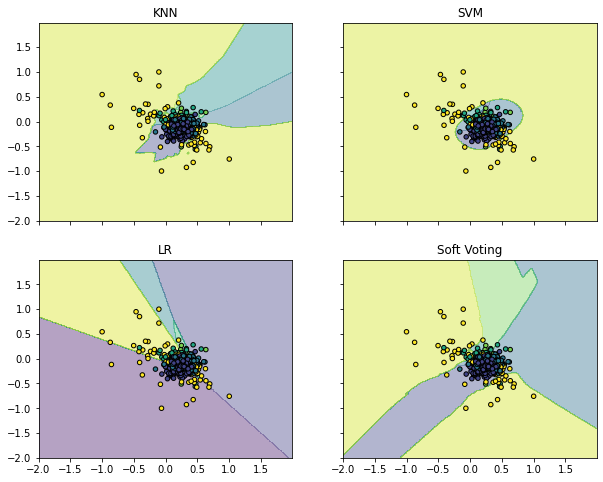

In [53]:
# 展示结果
x_min, x_max = x_t[:,0].min() -1, x_t[:,0].max() + 1
y_min, y_max = x_t[:,1].min() -1, x_t[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))  #创建网格

fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8)) #共享X轴和Y轴

for idx, clf, title in zip(product([0, 1],[0, 1]),
                           [clf1, clf2, clf6, eclf_soft],
                           ['KNN', 'SVM',
                            'LR', 'Soft Voting']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #起初我以为是预测的X的值，实际上是预测了上面创建的网格的值，以这些值来进行描绘区域
    Z = Z.reshape(xx.shape)
    axes[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axes[idx[0], idx[1]].scatter(x_t[:, 0],x_t[:, 1], c=x_test, s=20, edgecolor='k')
    axes[idx[0], idx[1]].set_title(title)
plt.show()

##### （三）训练模型-软投票展示混淆矩阵和结果

In [55]:
# 模型分批训练
clf1.fit(x_train,x_test)
clf2.fit(x_train,x_test)
clf3.fit(x_train,x_test)
clf4.fit(x_train,x_test)
clf5.fit(x_train,x_test)
clf6.fit(x_train,x_test)
# 投票模型训练
eclf_soft.fit(x_train,x_test)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('SVM', SVC(probability=True)),
                             ('MLP', MLPClassifier()),
                             ('LR', LogisticRegression())],
                 voting='soft', weights=[1, 2, 2, 2])

In [56]:
names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'
}

In [57]:
# 定义函数用于生成混淆矩阵
def CreateCM(prediction,y_true,name):
    # 查看结果
    prediction_new = pd.DataFrame(prediction)
    prediction_new.columns=['activity']
    # 对预测结果数量进行统计
    # prediction_new['activity'].value_counts()
    # 对预测结果标签进行数字替换，按names进行替换
    prediction_new['activity']= prediction_new['activity'].map(names)
    # 查看预测结果信息
    # prediction_new['activity'].describe()
    # prediction_new['activity'].value_counts()
    
#     # 对prediciton 作-1处理
#     i = 0
#     for value in prediction:
#         prediction[i]=value-1
#         i = i+1
#     # 对y_test 作-1处理
#     i = 0
#     for value in y_test:
#         y_true[i]=value-1
#         i = i+1
    # 混淆矩阵可视化
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import plot_confusion_matrix
    # 生成获取混淆矩阵
    cm = confusion_matrix(y_true=y_true,y_pred=prediction)   
    
    # 混淆矩阵信息添加
    columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    cm_df = pd.DataFrame(cm)
    cm_df.columns = columns
    cm_df.index = columns

    #转换成dataframe，转不转一样
    #fmt参数不使用科学计数法进行显示
#     plt.xticks(fontsize=8) 
#     plt.yticks(fontsize=8)
    ax = sns.heatmap(cm_df,annot=True,fmt='.20g',center=120,vmin=0,vmax=600)
    ax.set_title('confusion matrix') #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    
    # 存储图片
    # plt.savefig('论文图表资料/其他对比算法的预测结果（混淆矩阵展示）/'+name+'.tif',format='tif',bbox_inches='tight')
    # 设置xy轴刻度文字大小 
    return cm

In [58]:
# 定义函数用于输出精确率和召回率
def process(cm):
    x = [0,0,0,0,0,0]
    y = [0,0,0,0,0,0]
    for i in range(0,6):
        sumrow_i = sum(cm[i])
        sumcol_i = sum(cm.T[i])

        x[i] = cm[i][i]/sumrow_i
        y[i] = cm[i][i]/sumcol_i
    print("精确率：",np.sum(x)/6*100,'%' )
    print("召回率：",np.sum(y)/6*100,'%' )

##### （三）评估模型 Evaluation model

精确率： 95.14122863836057 %
召回率： 95.50867842245596 %


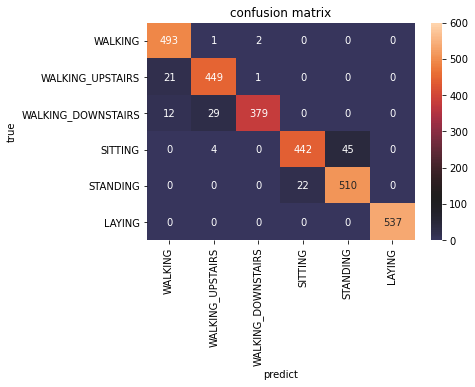

In [62]:
# 硬投票
prediction = eclf.predict(y_train)
# 计算混淆矩阵
c = CreateCM(prediction,y_test,'Hard_voting')
# 输出精确率和召回率
process(c)

精确率： 95.86940023651918 %
召回率： 96.23319221842615 %


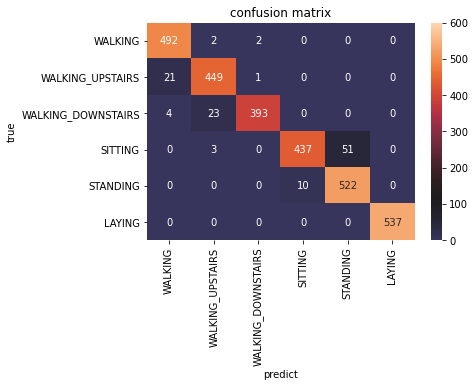

In [59]:
# 软投票
prediction = eclf_soft.predict(y_train)
# 计算混淆矩阵
c = CreateCM(prediction,y_test,'Soft_voting')
# 输出精确率和召回率
process(c)

##### （四）模型预测 Model prediction

In [25]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,[0,2]] #取两列，方便绘图
y = iris.target

In [30]:
x_t = x_train[:,[0,2]]
x_t

array([[ 0.28858451, -0.13290514],
       [ 0.27841883, -0.12352019],
       [ 0.27965306, -0.11346169],
       ...,
       [ 0.27338737, -0.04502183],
       [ 0.28965416, -0.15828059],
       [ 0.35150347, -0.20386717]])

In [31]:
X

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4],
       [5.4, 1.7],
       [4.6, 1.4],
       [5. , 1.5],
       [4.4, 1.4],
       [4.9, 1.5],
       [5.4, 1.5],
       [4.8, 1.6],
       [4.8, 1.4],
       [4.3, 1.1],
       [5.8, 1.2],
       [5.7, 1.5],
       [5.4, 1.3],
       [5.1, 1.4],
       [5.7, 1.7],
       [5.1, 1.5],
       [5.4, 1.7],
       [5.1, 1.5],
       [4.6, 1. ],
       [5.1, 1.7],
       [4.8, 1.9],
       [5. , 1.6],
       [5. , 1.6],
       [5.2, 1.5],
       [5.2, 1.4],
       [4.7, 1.6],
       [4.8, 1.6],
       [5.4, 1.5],
       [5.2, 1.5],
       [5.5, 1.4],
       [4.9, 1.5],
       [5. , 1.2],
       [5.5, 1.3],
       [4.9, 1.4],
       [4.4, 1.3],
       [5.1, 1.5],
       [5. , 1.3],
       [4.5, 1.3],
       [4.4, 1.3],
       [5. , 1.6],
       [5.1, 1.9],
       [4.8, 1.4],
       [5.1, 1.6],
       [4.6, 1.4],
       [5.3, 1.5],
       [5. , 1.4],
       [7. , 4.7],
       [6.4, 4.5],
       [6.9,